In [1]:
import numpy as np 
import scipy.stats
import pandas as pd
import seaborn as sns
import random
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline
 
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans,DBSCAN,SpectralClustering,AgglomerativeClustering,Birch
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn import svm

## Generate Random 2D Data : with labels

In [2]:
n = 100
mean_1 = [0,0]
cov_1 = [[10,-50],
        [-50, 100]] 
# x,y = np.random.multivariate_normal(mean_1,cov_1,n).T

mean_2 = [30,50]
cov_2 = [[10,70],
        [70,100]] 
# x_2,y_2 = np.random.multivariate_normal(mean_2,cov_2,n).T
random.seed(123)
x,y = np.append(np.random.multivariate_normal(mean_1,cov_1,n).T,
                 np.random.multivariate_normal(mean_2,cov_2,n).T,
                axis=1
                )

data = pd.DataFrame({'x':x,'y':y})
del x,y
data['label'] = np.append(np.repeat(0,n),np.repeat(1,n),axis = 0)
data['Constrained_label'] = [2 if (xx>0 and yy < 0) else zz for (xx,yy,zz) in zip(data.x,data.y,data.label)]
data.reset_index(inplace=True)
data.head()

,index,x,y,label,Constrained_label
0,0,-1.461891,-9.622494,0,0
1,1,2.281378,1.727968,0,0
2,2,-2.687412,9.851049,0,0
3,3,-1.759896,12.095669,0,0
4,4,0.170738,-8.951244,0,2


In [3]:
print("Unique Lables in data :",data.Constrained_label.unique())
scale = StandardScaler()
stand_data = pd.DataFrame(scale.fit_transform(data.iloc[:,0:2]),columns = ['x','y'])
stand_data['Constrained_label'] = data.Constrained_label
stand_data.iloc[:,0:2].to_csv("./data.txt",header = False,index = False,sep = "\t")
stand_data.head()

Unique Lables in data : [0 2 1]


,x,y,Constrained_label
0,-1.723412,-1.020988,0
1,-1.706091,-0.786022,0
2,-1.688771,-1.097914,0
3,-1.671450,-1.039694,0
4,-1.654129,-0.918507,2


In [4]:
class makeConstraintFileCsv():

    def __init__(self,data,cluster_number):
        self.data = data
        self.cluster_number = cluster_number
        
        assert isinstance(self.data,pd.DataFrame)
        assert isinstance(self.cluster_number, int)
        # print('AllGood')

    def make_file(self,file_name):
        from itertools import combinations,product,chain
        
        self.data = self.data
        # const_data = self.data[(self.data.x > 0) & (self.data.y<0)]
        ml_list = []
        cl_list = []
        for lbl in np.unique(self.data.Constrained_label):
            ml_list = list(chain(ml_list,
                                [(i,j,1) for (i,j) in list(combinations(self.data.index[self.data.Constrained_label == lbl], 2))]
                                ))

        for (x,y) in list(combinations(np.unique(self.data.Constrained_label),2)):
            cl_list = list(chain(cl_list,
                                [(i,j,-1) for (i,j) in list(product(self.data.index[self.data.Constrained_label == x], self.data.index[self.data.Constrained_label == y]))]
                                ))
        total_list  = list(chain(ml_list,cl_list))

        random_list = random.sample(range(0, len(total_list)), int(len(total_list)*0.01))

        f=open(file_name,'w')
        for ele in [total_list[i] for i in random_list]:
            for element in ele:
                f.write(str(element)+'\t')
            f.write('\n')
        f.close()

x = makeConstraintFileCsv(data,3)
x.make_file('constraints_file.csv')

# data['Constrained_label'] = [2 if (xx>0 and yy < 0) else zz for (xx,yy,zz) in zip(data.x,data.y,data.label)]

CPU times: user 513 ms, sys: 57.4 ms, total: 570 ms
Wall time: 261 ms


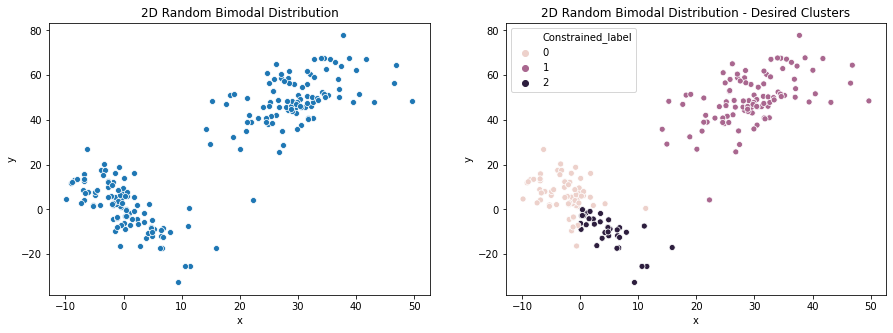

In [5]:
%%time 
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.scatterplot(data.x,data.y).set_title("2D Random Bimodal Distribution")
plt.subplot(122)
sns.scatterplot(data.x,data.y,hue=data.Constrained_label).set_title("2D Random Bimodal Distribution - Desired Clusters")
plt.savefig("./ExpectedOutput.png")

In [9]:
result = pd.read_csv("./output.txt",header=None)
result.columns = ['col']
# print(result.columns)
print(np.unique(result.col))
# print(len(pd.Series(result['2'])))
x = list(pd.Series(result['col']))
data['new'] = x
data.head()

[0 1 2]


,index,x,y,label,Constrained_label,new
0,0,-1.461891,-9.622494,0,0,2
1,1,2.281378,1.727968,0,0,2
2,2,-2.687412,9.851049,0,0,2
3,3,-1.759896,12.095669,0,0,2
4,4,0.170738,-8.951244,0,2,0


Text(0.5, 1.0, '2D Random Bimodal Distribution - Desired Clusters')

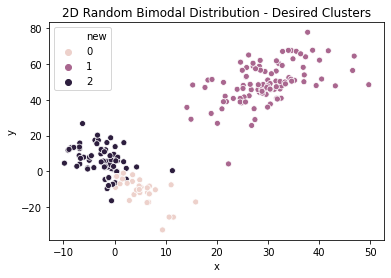

In [10]:
sns.scatterplot(data.x,data.y,hue=data.new).set_title("2D Random Bimodal Distribution - Desired Clusters")  